# **Экзамен** 

---

### **Выполнил**:  
**Вольхин Данил Федорович**

### **Email**:  
[dfvolkhin@edu.hse.ru](mailto:dfvolkhin@edu.hse.ru)

### **Дата**:  
**26 октября 2024**

---

😊 Последний раз запускаем джупитер и пандас 😊

# Импорт библиотек

In [46]:
# Импорт библиотек
import time
import numpy as np
from scipy.stats import beta
import matplotlib
import matplotlib.pyplot as plt
from duckdb import duckdb
import pandas as pd
import hashlib
import kagglehub
from tqdm import tqdm
import seaborn as sns
import math
import pandas as pd
import random
import imageio
import os
from scipy.stats import norm
from typing import Union
from datetime import timedelta
import math

## Формулировка задания

https://www.kaggle.com/datasets/alexxl/zvuk-dataset

    * Время за сессию
    * Время на юзера
    * Доля «непрослушанных» треков



1. Провести EDA, выяснить, что в большей степени влияет на указанные метрики. 

2. Насколько перспективным было бы использовать CUPED (сильно ли коррелирует текущая история метрики с ее предысторией?).

3. В течение какого времени необходимо проводить тест (и на каком объеме аудитории), чтобы «заметить» изменение в 3-5% на указанной метрике.

## Качаем данные

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alexxl/zvuk-dataset")

print("Path to dataset files:", path)

C:\Users\NightMare\PycharmProjects\DataAnalysisTools\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 2.24G/2.24G [07:17<00:00, 5.49MB/s]

Extracting files...


Path to dataset files: C:\Users\NightMare\.cache\kagglehub\datasets\alexxl\zvuk-dataset\versions\1


## Че с данными

In [4]:
path

'C:\\Users\\NightMare\\.cache\\kagglehub\\datasets\\alexxl\\zvuk-dataset\\versions\\1'

In [16]:
df = pd.read_parquet("C:/Users/NightMare/.cache/kagglehub/datasets/alexxl/zvuk-dataset/versions/1/zvuk-interactions.parquet")

In [17]:
df

,user_id,session_id,datetime,track_id,play_duration
0,1938823.0,2200336.0,2023-03-18 11:43:57.856,1242546.0,23.999992
1,1938823.0,2200336.0,2023-03-18 11:43:58.114,145031.0,2.000000
2,1938823.0,2200336.0,2023-03-18 11:45:12.932,145031.0,34.000000
3,1938823.0,2200336.0,2023-03-18 11:45:27.808,1501837.0,18.000000
4,1938823.0,2200336.0,2023-03-18 11:45:42.891,1402020.0,2.000000
...,...,...,...,...,...
244673546,7403165.0,10525448.0,2023-05-12 17:00:44.664,1232425.0,78.000000
244673547,7403165.0,10525448.0,2023-05-12 17:01:50.090,1163763.0,62.999996
244673548,7403165.0,10525448.0,2023-05-12 17:05:48.489,1501329.0,236.000000
244673549,7403165.0,10525448.0,2023-05-12 17:06:56.749,1232425.0,67.000000


## Типо EDA

Время за пользователя - обычная метрика, которая зависит только от пользователя <br/>
Время за сессию - обычная метрика, которая зависит от пользователя, но так как у одного пользователя может быть много сессий, <br/>
нужно учитывать при рандомизации по пользователям, что в бакеты нужно раскидывать сессии так, чтобы разные пользователи были в разных бакетах <br/>
Доля непрослушанных треков - ratio метрика, отношение непрослушанных треков ко всем трекам <br/>


In [18]:
# Проверка ну дубликатов и пропусков
print(df.duplicated().sum())
print(df.isnull().sum())

388399
user_id          0
session_id       0
datetime         0
track_id         0
play_duration    0
dtype: int64


In [25]:
df = df.drop_duplicates()

In [26]:
df['datatime'] = pd.to_datetime(df['datetime'])

C:\Temp\ipykernel_13440\116881212.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['datatime'] = pd.to_datetime(df['datetime'])


In [28]:
df.head()

,user_id,session_id,datetime,track_id,play_duration,datatime
0,1938823.0,2200336.0,2023-03-18 11:43:57.856,1242546.0,23.999992,2023-03-18 11:43:57.856
1,1938823.0,2200336.0,2023-03-18 11:43:58.114,145031.0,2.000000,2023-03-18 11:43:58.114
2,1938823.0,2200336.0,2023-03-18 11:45:12.932,145031.0,34.000000,2023-03-18 11:45:12.932
3,1938823.0,2200336.0,2023-03-18 11:45:27.808,1501837.0,18.000000,2023-03-18 11:45:27.808
4,1938823.0,2200336.0,2023-03-18 11:45:42.891,1402020.0,2.000000,2023-03-18 11:45:42.891


In [29]:
df.tail()

,user_id,session_id,datetime,track_id,play_duration,datatime
244673546,7403165.0,10525448.0,2023-05-12 17:00:44.664,1232425.0,78.000000,2023-05-12 17:00:44.664
244673547,7403165.0,10525448.0,2023-05-12 17:01:50.090,1163763.0,62.999996,2023-05-12 17:01:50.090
244673548,7403165.0,10525448.0,2023-05-12 17:05:48.489,1501329.0,236.000000,2023-05-12 17:05:48.489
244673549,7403165.0,10525448.0,2023-05-12 17:06:56.749,1232425.0,67.000000,2023-05-12 17:06:56.749
244673550,7403165.0,3918670.0,2023-05-12 17:55:38.727,364727.0,190.000000,2023-05-12 17:55:38.727


### Чето данных дохера, давайте ка рассмотрим только последнюю неделю

In [30]:
min_date = df['datetime'].min()
max_date = df['datetime'].max()

print(f"Старт отчета времени: ", min_date)
print(f"Конец отчета времени: ", max_date)

Старт отчета времени:  2023-01-15 00:00:00.074000
Конец отчета времени:  2023-05-14 20:59:59.994000


In [34]:
last_week_start = max_date - pd.DateOffset(weeks=1)
df = df[(df['datetime'] >= last_week_start) & (df['datetime'] <= max_date)]

In [35]:
df.head()

,user_id,session_id,datetime,track_id,play_duration,datatime
167,7984868.0,11290960.0,2023-05-13 14:07:58.308,381499.0,192.000000,2023-05-13 14:07:58.308
168,7984868.0,11290960.0,2023-05-13 14:07:58.361,950596.0,250.000000,2023-05-13 14:07:58.361
169,7984868.0,11290960.0,2023-05-13 14:07:58.381,950596.0,116.000000,2023-05-13 14:07:58.381
170,7984868.0,11290960.0,2023-05-13 14:07:58.389,1291941.0,0.999992,2023-05-13 14:07:58.389
171,7984868.0,11290960.0,2023-05-13 14:07:58.720,1257446.0,150.000000,2023-05-13 14:07:58.720


In [36]:
df.tail()

,user_id,session_id,datetime,track_id,play_duration,datatime
244673546,7403165.0,10525448.0,2023-05-12 17:00:44.664,1232425.0,78.000000,2023-05-12 17:00:44.664
244673547,7403165.0,10525448.0,2023-05-12 17:01:50.090,1163763.0,62.999996,2023-05-12 17:01:50.090
244673548,7403165.0,10525448.0,2023-05-12 17:05:48.489,1501329.0,236.000000,2023-05-12 17:05:48.489
244673549,7403165.0,10525448.0,2023-05-12 17:06:56.749,1232425.0,67.000000,2023-05-12 17:06:56.749
244673550,7403165.0,3918670.0,2023-05-12 17:55:38.727,364727.0,190.000000,2023-05-12 17:55:38.727


In [37]:
df

,user_id,session_id,datetime,track_id,play_duration,datatime
167,7984868.0,11290960.0,2023-05-13 14:07:58.308,381499.0,192.000000,2023-05-13 14:07:58.308
168,7984868.0,11290960.0,2023-05-13 14:07:58.361,950596.0,250.000000,2023-05-13 14:07:58.361
169,7984868.0,11290960.0,2023-05-13 14:07:58.381,950596.0,116.000000,2023-05-13 14:07:58.381
170,7984868.0,11290960.0,2023-05-13 14:07:58.389,1291941.0,0.999992,2023-05-13 14:07:58.389
171,7984868.0,11290960.0,2023-05-13 14:07:58.720,1257446.0,150.000000,2023-05-13 14:07:58.720
...,...,...,...,...,...,...
244673546,7403165.0,10525448.0,2023-05-12 17:00:44.664,1232425.0,78.000000,2023-05-12 17:00:44.664
244673547,7403165.0,10525448.0,2023-05-12 17:01:50.090,1163763.0,62.999996,2023-05-12 17:01:50.090
244673548,7403165.0,10525448.0,2023-05-12 17:05:48.489,1501329.0,236.000000,2023-05-12 17:05:48.489
244673549,7403165.0,10525448.0,2023-05-12 17:06:56.749,1232425.0,67.000000,2023-05-12 17:06:56.749


In [39]:
df.sort_values(by='datetime')

,user_id,session_id,datetime,track_id,play_duration,datatime
60843971,1286084.0,11865782.0,2023-05-07 21:00:00.242,400174.0,29.999992,2023-05-07 21:00:00.242
200306768,8200849.0,1356648.0,2023-05-07 21:00:00.274,1442989.0,263.000000,2023-05-07 21:00:00.274
206274087,7388631.0,6621765.0,2023-05-07 21:00:00.821,1359546.0,235.000000,2023-05-07 21:00:00.821
13579130,8492723.0,3622230.0,2023-05-07 21:00:00.899,1329570.0,2.999992,2023-05-07 21:00:00.899
200658347,6790360.0,1834010.0,2023-05-07 21:00:01.052,1019026.0,50.999996,2023-05-07 21:00:01.052
...,...,...,...,...,...,...
23827260,7994202.0,10935073.0,2023-05-14 20:59:59.089,444873.0,93.000000,2023-05-14 20:59:59.089
219218912,5028900.0,4602971.0,2023-05-14 20:59:59.735,493125.0,13.999992,2023-05-14 20:59:59.735
117311784,8056611.0,1469042.0,2023-05-14 20:59:59.942,974941.0,2.999992,2023-05-14 20:59:59.942
117311785,8056611.0,1469042.0,2023-05-14 20:59:59.988,974941.0,-1.000008,2023-05-14 20:59:59.988


### Считаем метрики

In [150]:
# Считаем метрику время за сессию
session_time = df.groupby('session_id')['play_duration'].sum().reset_index()
session_time.columns = ['session_id', 'total_play_duration']
session_time = session_time.merge(df, on='session_id', how='left')
session_time = session_time[['session_id', 'user_id', 'total_play_duration']].drop_duplicates()
session_time['total_play_duration'] = session_time['total_play_duration'].astype('int')
session_time['user_id'] = session_time['user_id'].astype('int')

In [151]:
session_time

,session_id,user_id,total_play_duration
0,21.0,3116547,2970
24,23.0,9187639,1262
36,41.0,5086681,146
38,42.0,7272791,62
39,55.0,8790631,378
...,...,...,...
15376277,13027617.0,8820532,15316
15376465,13027649.0,5569184,2
15376466,13027692.0,3365230,161
15376470,13027704.0,3252766,437


In [154]:
# Считаем метрику время за юзера
user_time = df.groupby('user_id')['play_duration'].sum().reset_index()
user_time.columns = ['user_id', 'total_play_duration']
user_time['total_play_duration'] = user_time['total_play_duration'].astype('int')
user_time['user_id'] = user_time['user_id'].astype('int')

In [155]:
user_time

,user_id,total_play_duration
0,1000101,1663
1,1000332,30446
2,1000401,10400
3,1000477,6809
4,1000517,597
...,...,...
141634,9999686,11662
141635,9999859,2
141636,9999863,99
141637,9999880,33


In [159]:
# Метрика доля непрослушанных треков
# Определяем трек, который был непрослушан
unplayed_tracks = df[df['play_duration'] < 10].groupby('track_id')['play_duration'].count().reset_index()
unplayed_tracks.columns = ['track_id', 'unplayed_count']
# Общее количество прослушиваний
total_tracks = df.groupby('track_id')['play_duration'].count().reset_index()
total_tracks.columns = ['track_id', 'total_count']
# Агрегируем данные
track_stats = pd.merge(total_tracks, unplayed_tracks, on='track_id', how='left').fillna(0)
track_stats['total_count'] = track_stats['total_count'].astype('int')
track_stats['unplayed_count'] = track_stats['unplayed_count'].astype('int')
track_stats['track_id'] = track_stats['track_id'].astype('int')

In [160]:
track_stats

,track_id,total_count,unplayed_count
0,3,1,1
1,4,5,1
2,8,1,0
3,9,251,74
4,15,1,1
...,...,...,...
541364,1506939,2,0
541365,1506940,1,0
541366,1506945,2,0
541367,1506946,1,1


### Визуализация и корреляционный анализ

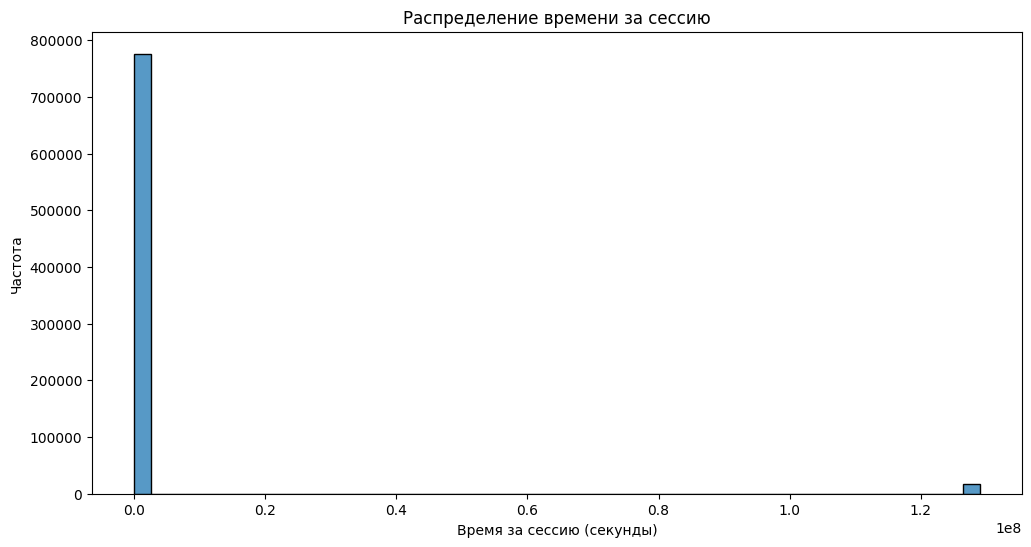

In [132]:
# Смотрим на распределение времени за сессию
plt.figure(figsize=(12, 6))
sns.histplot(session_time['total_play_duration'], bins=50)
plt.title('Распределение времени за сессию')
plt.xlabel('Время за сессию (секунды)')
plt.ylabel('Частота')
plt.show()

In [133]:
# Есть подозрительно огромные значения длительности, нужно их выкинуть
session_time = session_time[(session_time['total_play_duration'] <= 1000)]
session_time['total_play_duration'] = session_time['total_play_duration'].apply(lambda x: x if x >= 0 else 0)

C:\Temp\ipykernel_13440\2682097593.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session_time['total_play_duration'] = session_time['total_play_duration'].apply(lambda x: x if x >= 0 else 0)


In [134]:
# Еще раз посмотрим и оформим построение графика в функцию

def visualize_feature(features, name_metric):
    plt.figure(figsize=(12, 6))
    
    # Проверяем, является ли features списком и содержит ли он два столбца
    if isinstance(features, list) and len(features) == 2:
        # Строим две гистограммы с разными цветами
        sns.histplot(features[0], bins=50, color='skyblue', label=f"{name_metric.split(' ')[0]}")
        sns.histplot(features[1], bins=50, color='salmon', label=f"{name_metric.split(' ')[1]}")
        
        # Настройки графика
        plt.title(f'Распределение {name_metric[0]} и {name_metric[1]}')
        plt.xlabel(f'Время (секунды)')
        plt.ylabel(f'Частота')
        plt.legend()
        
    else:
        # Если передан один столбец, строим одну гистограмму
        sns.histplot(features, bins=50, color='skyblue')
        
        # Настройки графика
        plt.title(f'Распределение {name_metric}')
        plt.xlabel(f'Время (секунды)')
        plt.ylabel(f'Частота')
    
    plt.show()


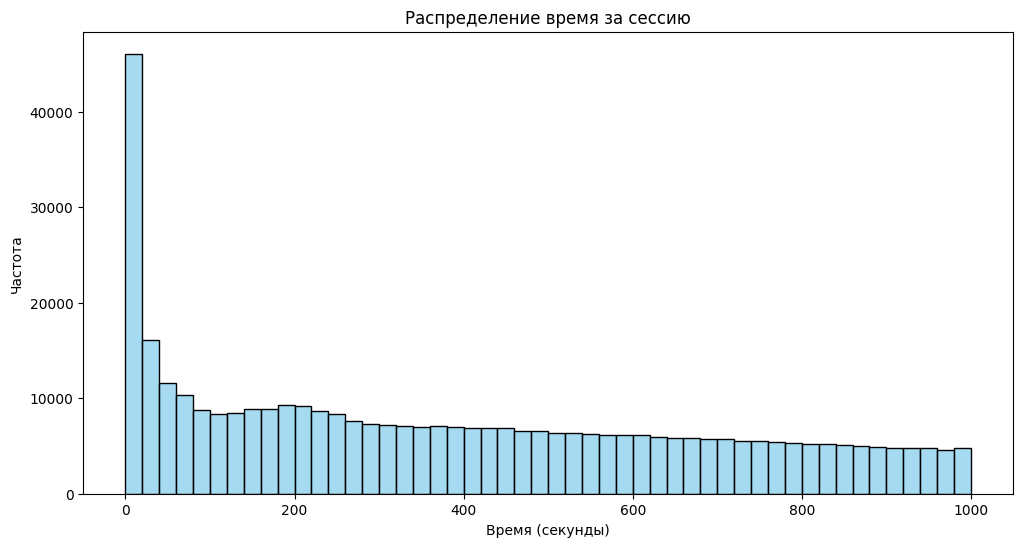

In [135]:
visualize_feature(session_time['total_play_duration'], 'время за сессию')

In [136]:
# Время игры трека в реальности, если речь о музыке, не больше 5 минут, учтем это
session_time = session_time[(session_time['total_play_duration'] <= 300)]

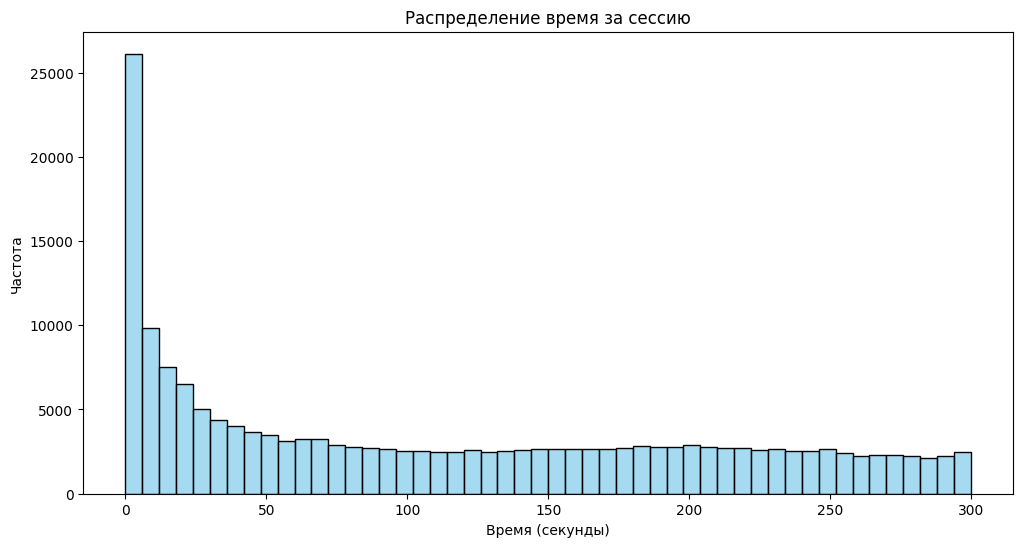

In [137]:
visualize_feature(session_time['total_play_duration'], 'время за сессию')

Выглядит вполне сносно, теперь посмотрим на время на пользователя

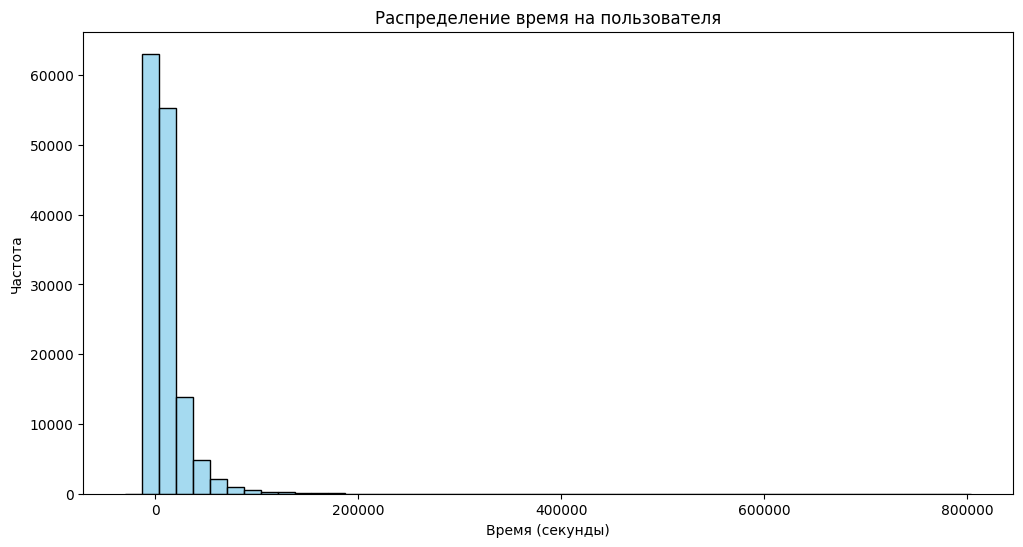

In [138]:
visualize_feature(user_time['total_play_duration'], 'время на пользователя')

Тоже самое, исключим треки длительностью дольше 300 секунд и отрицательные превратим в 0

In [139]:
# Есть подозрительно огромные значения длительности, нужно их выкинуть
user_time = user_time[(user_time['total_play_duration'] <= 1000)]
user_time['total_play_duration'] = user_time['total_play_duration'].apply(lambda x: x if x >= 0 else 0)

C:\Temp\ipykernel_13440\2521205978.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_time['total_play_duration'] = user_time['total_play_duration'].apply(lambda x: x if x >= 0 else 0)


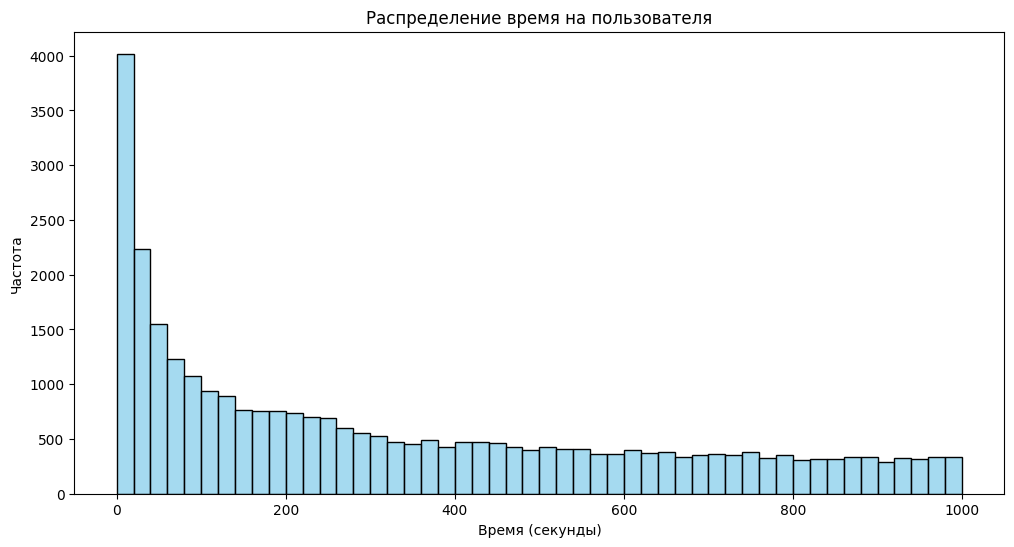

In [140]:
visualize_feature(user_time['total_play_duration'], 'время на пользователя')

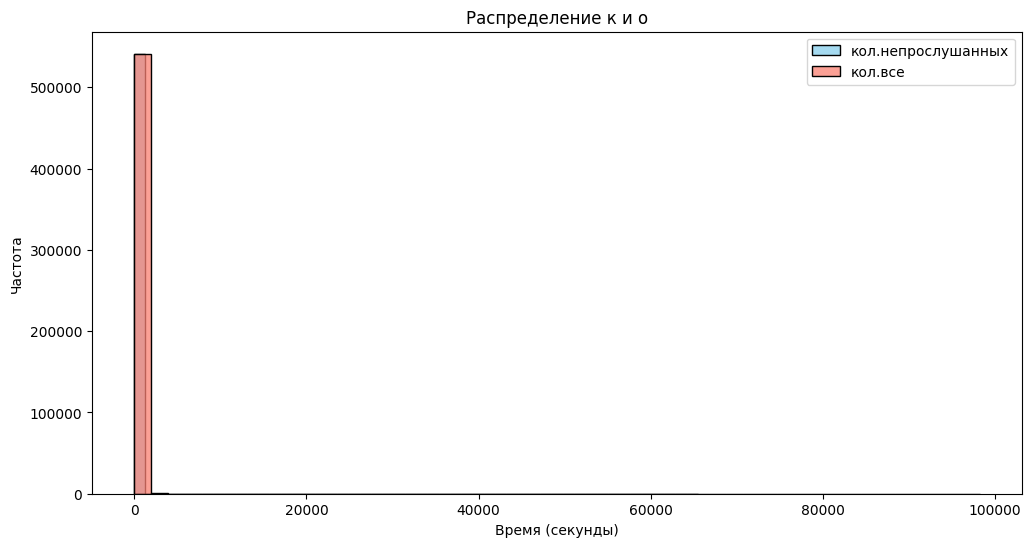

In [141]:
## Смотрим на данные доли прослушиваний
visualize_feature([track_stats['unplayed_count'], track_stats['total_count']], 'кол.непрослушанных кол.все')

In [145]:
# Есть подозрительно огромные значения длительности, нужно их выкинуть
track_stats['unplayed_count'] = track_stats['unplayed_count'].apply(lambda x: x if x >= 0 else 0)
track_stats['total_count'] = track_stats['total_count'].apply(lambda x: x if x >= 0 else 0)

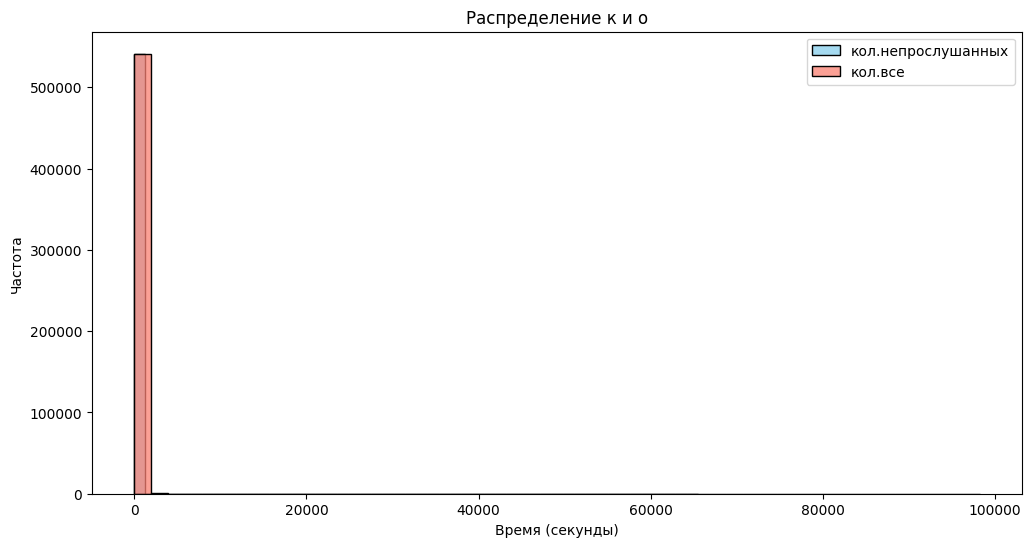

In [147]:
## Смотрим на данные доли прослушиваний
visualize_feature([track_stats['unplayed_count'], track_stats['total_count']], 'кол.непрослушанных кол.все')

## Определяем класс для бакетирования (100% от выборки = 100 бакетов)

In [161]:
class GetBacket:

    def __init__(self, n_buckets: int, salt: str = "SALT", hash_func: str = "md5"):
        # Инициализация количества бакетов и соли для хеширования
        self.n_buckets = n_buckets
        self.salt = salt

        if hash_func == "md5":
            self.hash_func = self.hash_md5
        elif hash_func == "sha256":
            self.hash_func = self.hash_sha256
        else:
            raise ValueError("Wrong name hash")

    def __call__(self, data: list) -> dict:
        """
        Вызывается при вызове экземпляра класса.
        Принимает на вход список данных (ID пользователей или сессий).
        Возвращает словарь с распределением данных по бакетам.
        """
        self.data = np.array(data, dtype=str)  # Преобразуем данные в массив строк
        return self.gen_random_buckets()

    @staticmethod
    def hash_md5(argument: str) -> int:
        """
        Хеш-функция на основе MD5.
        Возвращает целое число, полученное из хеша аргумента.
        """
        return int(hashlib.md5(argument.encode()).hexdigest(), 16)

    @staticmethod
    def hash_sha256(argument: str) -> int:
        """
        Хеш-функция на основе SHA256.
        Возвращает целое число, полученное из хеша аргумента.
        """
        return int(hashlib.sha256(argument.encode()).hexdigest(), 16)

    def gen_random_buckets(self) -> dict:
        """
        Генерирует рандомный идентификатор слоя и распределяет данные по бакетам.
        Возвращает словарь с распределением данных.
        """
        layer_id = "layer_test_" + str(np.random.choice(1000))  # Рандомный ID слоя
        buckets = self.split_data_to_buckets(self.data, layer_id)
        return buckets

    def split_data_to_buckets(self, data: np.ndarray, layer_id: str) -> dict:
        """
        Распределяет данные по бакетам на основе хеша.
        Возвращает словарь с ID, распределенными по бакетам.
        """
        buckets = {i: [] for i in range(self.n_buckets)}  # Инициализация пустых бакетов

        for item in data:
            # Генерируем случайное число для случайного распределения одинаковых ID по разным бакетам
            random_seed = np.random.randint(0, 1e6)
            hash_argument = str(item) + layer_id + self.salt + str(random_seed)
            # hash_argument = str(item) + layer_id + self.salt

            bucket_id = self.hash_func(hash_argument) % self.n_buckets  # Определение бакета
            buckets[bucket_id].append(int(item))  # Добавляем ID в соответствующий бакет

        return buckets

    def plot_bucket_distribution(self, data: np.ndarray, title: str):
        """
        Визуализация распределения данных по бакетам.
        """
        bucket_counts = self.get_bucket_counts(data)

        # Построение графика распределения
        plt.figure(figsize=(10, 6))
        plt.bar(range(self.n_buckets), bucket_counts, color="blue")
        plt.title(f"Распределение бакетов хэшом: {self.hash_func.__name__}\n{title}")
        plt.xlabel("Номер бакета")
        plt.ylabel("Количество данных")
        plt.grid(True)
        plt.show()
        plt.close()

    def get_bucket_counts(self, data: np.ndarray) -> list:
        """
        Получение количества элементов в каждом бакете для визуализации.
        Возвращает список с количеством данных в каждом бакете.
        """
        buckets = self.split_data_to_buckets(data, "layer_visualization_" + str(np.random.choice(1000)))
        return [len(buckets[i]) for i in range(self.n_buckets)]

In [162]:
# Инициализация класса
get_backet = GetBacket(100, "EXZ", "sha256")

# Пример использования для разных данных
session_time_ids = get_backet(session_time['user_id'].to_list())
user_time_ids = get_backet(user_time['user_id'].to_list())
track_stats_ids = get_backet(track_stats['track_id'].to_list())

In [163]:
print(60*"-")
[print(f"backet_id: {backet_id}, values: {values[:5]}") for idx, (backet_id, values) in enumerate(session_time_ids.items()) if idx < 5]
print("backet_id: ...")
print(60*"-")
[print(f"backet_id: {backet_id}, values: {values[:5]}") for idx, (backet_id, values) in enumerate(user_time_ids.items()) if idx < 5]
print("backet_id: ...")
print(60*"-")
[print(f"backet_id: {backet_id}, values: {values[:5]}") for idx, (backet_id, values) in enumerate(track_stats_ids.items()) if idx < 5]
print("backet_id: ...")
print(60*"-")

------------------------------------------------------------
backet_id: 0, values: [7406414, 9349873, 5268642, 3806365, 5966315]
backet_id: 1, values: [6793598, 8395343, 2338810, 3536991, 7818877]
backet_id: 2, values: [2207532, 2293289, 5329893, 6301173, 2496965]
backet_id: 3, values: [7328791, 3111016, 2565039, 2609633, 4092742]
backet_id: 4, values: [6797941, 9129474, 7151186, 1957694, 9887412]
backet_id: ...
------------------------------------------------------------
backet_id: 0, values: [1006004, 1023626, 1024578, 1026548, 1027954]
backet_id: 1, values: [1003482, 1007886, 1014409, 1020434, 1024220]
backet_id: 2, values: [1024985, 1028460, 1034712, 1037569, 1039851]
backet_id: 3, values: [1004892, 1026155, 1030606, 1040720, 1041514]
backet_id: 4, values: [1011708, 1019766, 1023768, 1027055, 1033506]
backet_id: ...
------------------------------------------------------------
backet_id: 0, values: [460, 524, 1253, 1447, 1497]
backet_id: 1, values: [100, 390, 804, 1187, 1285]
backet

## Общий класс для расчета размера выборки

In [171]:
class CalcSampleSize(object):

    def __init__(self):
        # Процент из генеральной совокупности
        self.slices = [1,5,10,20,30,40,50]

    def __call__(self,
                 df: pd.DataFrame,
                 buckets: dict,
                 target: str,
                 ratio: bool = False) -> int:
        return self.calc_sample_size(df, buckets, target, ratio=False)

    @staticmethod
    def agg_sum(array):
      return sum(array)

    @staticmethod
    def agg_avg(array):
        return np.mean(array)

    @staticmethod
    def agg_ratio(array):
        # Вычисляем отношение сумм двух столбцов
        return array[0] / array[1] if array[1] != 0 else 0

    @staticmethod
    def diff(test, control):
      return [test_i - control_i for (test_i,control_i) in zip(test,control)]

    def calc_sample_size(self, df, backets):
        raise NotImplementedError

## Бутстреп

In [188]:
def bootstrap(test, control, func_agg, func_diff,
              ratio=False, poisson=True, n_iterations=1000):
    function_agg = func_agg
    function_diff = func_diff

    size = min(len(test[0]), len(control[0])) if ratio else min(len(test), len(control))
    t_list = []
    c_list = []
    np.random.seed(seed=42)

    for _ in range(n_iterations):
        if poisson:
            test_weights = np.random.poisson(1, size) 
            control_weights = np.random.poisson(1, size)

            if ratio:
                # Разделяем на два столбца и применяем веса отдельно к каждому
                test_agg = function_agg([np.sum(test[0][:size] * test_weights), 
                                         np.sum(test[1][:size] * test_weights)])
                control_agg = function_agg([np.sum(control[0][:size] * control_weights), 
                                            np.sum(control[1][:size] * control_weights)])
            else:
                test_agg = function_agg(test[:size] * test_weights)
                control_agg = function_agg(control[:size] * control_weights)

        else:
            # Классический бутстреп
            if ratio:
                test_agg = function_agg([np.sum(np.random.choice(test[0], size=size, replace=True)),
                                         np.sum(np.random.choice(test[1], size=size, replace=True))])
                control_agg = function_agg([np.sum(np.random.choice(control[0], size=size, replace=True)),
                                            np.sum(np.random.choice(control[1], size=size, replace=True))])
            else:
                test_agg = function_agg(np.random.choice(a=test, size=size, replace=True))
                control_agg = function_agg(np.random.choice(a=control, size=size, replace=True))
        
        t_list.append(test_agg)
        c_list.append(control_agg)

    t_list = np.array(t_list)
    c_list = np.array(c_list)
    result = function_diff(t_list, c_list)

    ci_all = np.quantile(result, 0.025).round(2), np.quantile(result, 0.975).round(2)
    minimum_lift = float((np.quantile(result, 0.975) - np.quantile(result, 0.025)) / 2)
    mde = minimum_lift / np.std(c_list)
    users = size
    
    return ci_all, minimum_lift, mde, result, users

In [189]:
class BootstrapSampleSize(CalcSampleSize):

    def init(self, n_iterations=100):
        """
        BootstrapSampleSize
        """
        super(BootstrapSampleSize, self).init()
        self.n_iterations = n_iterations

    def calc_sample_size(self, df, buckets, target, ratio=False):
        n_items = []
        minimum_lifts = []
        mdes = []
        userss = []
        results = []

        with tqdm (total=len(self.slices)) as pbar:
            for i in self.slices:

                if isinstance(target, list):

                    # Выбор первых i бакетов
                    selected_buckets_test = list(buckets.keys())[:i]
    
                    # Сбор всех data из выбранных первых i бакетов в один список
                    combined_data_test = []
                    for bucket_id in selected_buckets_test:
                        combined_data_test.extend(buckets[bucket_id])
    
                    # Формирование выборки для test
                    test = [df[df['track_id'].isin(combined_data_test)][target[0]].to_list(), df[df['track_id'].isin(combined_data_test)][target[1]].to_list()]
    
                    # Выбор бакетов для control: от i до 2*i
                    selected_buckets_control = list(buckets.keys())[i:2*i]
    
                    # Сбор всех data из бакетов для control в один список
                    combined_data_control = []
                    for bucket_id in selected_buckets_control:
                        combined_data_control.extend(buckets[bucket_id])
    
                    # Формирование выборки для control
                    control = [df[df['track_id'].isin(combined_data_control)][target[0]].to_list(), df[df['track_id'].isin(combined_data_control)][target[1]].to_list()]

                else:
                
                    # Выбор первых i бакетов
                    selected_buckets_test = list(buckets.keys())[:i]
    
                    # Сбор всех data из выбранных первых i бакетов в один список
                    combined_data_test = []
                    for bucket_id in selected_buckets_test:
                        combined_data_test.extend(buckets[bucket_id])
    
                    # Формирование выборки для test
                    test = df[df['user_id'].isin(combined_data_test)][target].to_list()
    
                    # Выбор бакетов для control: от i до 2*i
                    selected_buckets_control = list(buckets.keys())[i:2*i]
    
                    # Сбор всех data из бакетов для control в один список
                    combined_data_control = []
                    for bucket_id in selected_buckets_control:
                        combined_data_control.extend(buckets[bucket_id])
    
                    # Формирование выборки для control
                    control = df[df['user_id'].isin(combined_data_control)][target].to_list()

                # Запускаем бустреп
                _, minimum_lift, mde, result, users = bootstrap(test,
                                                                control,
                                                                self.agg_avg,
                                                                self.diff,
                                                                ratio)

                minimum_lifts.append(minimum_lift)
                mdes.append(mde)
                results.append(result)
                userss.append(users)
                n_items.append(i)

                pbar.update(1)
                pbar.set_description(f"Процент от выборки: {i}%")

            return pd.DataFrame({'minimum_lift': minimum_lifts, 'mde': mdes,
                                 'n_items': n_items, 'users': userss}), results


In [ ]:
exact = BootstrapSampleSize()
sample_size_session_time_exact, _ = exact(session_time, session_time_ids, 'total_play_duration')
sample_size_user_time_exact, _ = exact(user_time, user_time_ids, 'total_play_duration')
# sample_size_track_stats_exact, _ = exact(track_stats, track_stats_ids, ['total_count', 'unplayed_count'], True)

print(60*"-")
print("Методом бутстрепа размер выборки для времени на сессию: \n", sample_size_session_time_exact)
print("Методом бутстрепа размер выборки для времени на пользователя: \n", sample_size_user_time_exact)
# print("Методом бутстрепа размер выборки для доли прослушиваний: \n", sample_size_track_stats_exact)
print(60*"-")

Процент от выборки: 1%:  14%|█▍        | 1/7 [00:12<01:14, 12.47s/it]

## Что там по времени? 

In [ ]:
def time_needed(df, buckets, target, i):
    if isinstance(target, list):

                    # Выбор первых i бакетов
                    selected_buckets_test = list(buckets.keys())[:i]
    
                    # Сбор всех data из выбранных первых i бакетов в один список
                    combined_data_test = []
                    for bucket_id in selected_buckets_test:
                        combined_data_test.extend(buckets[bucket_id])
    
                    # Формирование выборки для test
                    test = [df[df['track_id'].isin(combined_data_test)][target[0]].to_list(), df[df['track_id'].isin(combined_data_test)][target[1]].to_list()]
    
                    # Выбор бакетов для control: от i до 2*i
                    selected_buckets_control = list(buckets.keys())[i:2*i]
    
                    # Сбор всех data из бакетов для control в один список
                    combined_data_control = []
                    for bucket_id in selected_buckets_control:
                        combined_data_control.extend(buckets[bucket_id])
    
                    # Формирование выборки для control
                    control = [df[df['track_id'].isin(combined_data_control)][target[0]].to_list(), df[df['track_id'].isin(combined_data_control)][target[1]].to_list()]

                else:
                
                    # Выбор первых i бакетов
                    selected_buckets_test = list(buckets.keys())[:i]
    
                    # Сбор всех data из выбранных первых i бакетов в один список
                    combined_data_test = []
                    for bucket_id in selected_buckets_test:
                        combined_data_test.extend(buckets[bucket_id])
    
                    # Формирование выборки для test
                    test = df[df['user_id'].isin(combined_data_test)][target].to_list()
    
                    # Выбор бакетов для control: от i до 2*i
                    selected_buckets_control = list(buckets.keys())[i:2*i]
    
                    # Сбор всех data из бакетов для control в один список
                    combined_data_control = []
                    for bucket_id in selected_buckets_control:
                        combined_data_control.extend(buckets[bucket_id])
    
                    # Формирование выборки для control
                    control = df[df['user_id'].isin(combined_data_control)][target].to_list()

    # Запускаем бустреп
    _, _, _, result, users = bootstrap(test, control, lambda x: np.mean(x), lambda x, y: x - y,
                                  ratio=False, n_iterations=1000)

    plt.figure(figsize=(12,5))
    plt.title(f"Распределение метрики разницы средних в A/A-симуляции: {target}")
    plt.hist(result, bins=50)
    plt.vlines([np.quantile(result, q=0.975),np.quantile(result, q=0.025),
                np.quantile(result, q=0.5)], ymin=0, ymax=50,
                linestyle='--', color='black')
    plt.show()

    wau = df['user_id'].nunique()
    days_weeks = users/wau*7
    print(f'Period from {days_weeks} days needed')

In [ ]:
# time_needed(purchases_first_14_days, purchases_per_session_ids, 'purchases', 10)